In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.0 MB/s eta 0:00:00


## Import Libraries

In [40]:
import cv2 as cv
import cv2
import os
import gc
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import classification_report

from skimage import segmentation

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Configurations

In [7]:
CONFIG = {
    "seed": 42,
    # "model_name": "tf_efficientnet_b0_ns",
    'model_name': "swin_tiny_patch4_window7_224",
    "checkpoint_path" : "/kaggle/input/swin_865/pytorch/default/1/best_model_896.pth",
    "num_classes" : 1,
    "batch_size": 64,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

## Reproducibility

In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

## Data loading

In [5]:
# Define the directory where test images are located
image_dir_test = '/kaggle/input/skin-cancer-detecttion/testX'

# Initialize an empty list to store image file paths and their corresponding IDs
data = []

# Check if the directory exists
if os.path.exists(image_dir_test):
    # Loop through each file in the directory
    for filename in os.listdir(image_dir_test):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
            image_path = os.path.join(image_dir_test, filename)
            data.append([image_path, filename])  # Append image path and filename

# Create a pandas DataFrame from the data
df_test = pd.DataFrame(sorted(data), columns=['image_path', 'id'])

In [33]:
image_dir_valid = '/kaggle/input/skin-cancer-detecttion/val'

classes = ['others', 'nevus']

# Initialize an empty list to store image file paths and their corresponding labels
data = []

# Loop through each class folder and each image within that folder
for c in classes:
    class_dir = os.path.join(image_dir_valid, c)
    
    if os.path.exists(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                image_path = os.path.join(class_dir, filename)
                data.append([image_path, filename, c])  # Append image path and filename
                # data.append([image_path, c])  # Append image path and its label (class)

# Create a pandas DataFrame from the data
df_valid = pd.DataFrame(data, columns=['image_path', 'id', 'label'])

In [34]:
df_valid['label'][df_valid['label']=='others'] = 0
df_valid['label'][df_valid['label']=='nevus'] = 1

In [35]:
df_valid

,image_path,id,label
0,/kaggle/input/skin-cancer-detecttion/val/other...,scc00396.jpg,0
1,/kaggle/input/skin-cancer-detecttion/val/other...,bcc02118.jpg,0
2,/kaggle/input/skin-cancer-detecttion/val/other...,bcc02281.jpg,0
3,/kaggle/input/skin-cancer-detecttion/val/other...,mel02759.jpg,0
4,/kaggle/input/skin-cancer-detecttion/val/other...,mel02790.jpg,0
...,...,...,...
3791,/kaggle/input/skin-cancer-detecttion/val/nevus...,nev08603.jpg,1
3792,/kaggle/input/skin-cancer-detecttion/val/nevus...,nev08113.jpg,1
3793,/kaggle/input/skin-cancer-detecttion/val/nevus...,nev08014.jpg,1
3794,/kaggle/input/skin-cancer-detecttion/val/nevus...,nev08654.jpg,1


## Sample data visualization

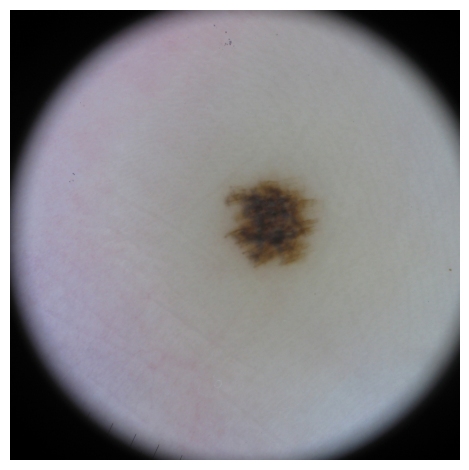

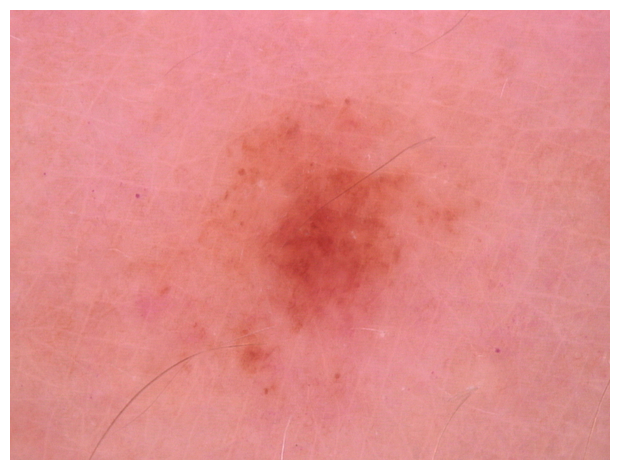

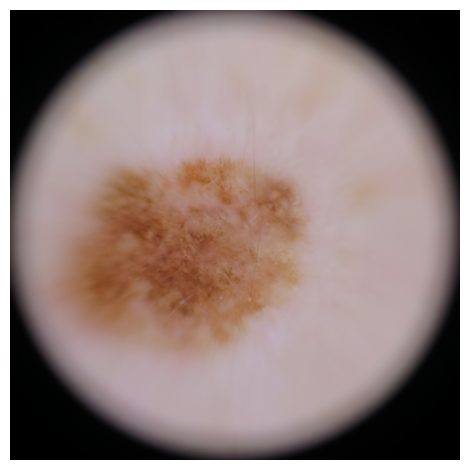

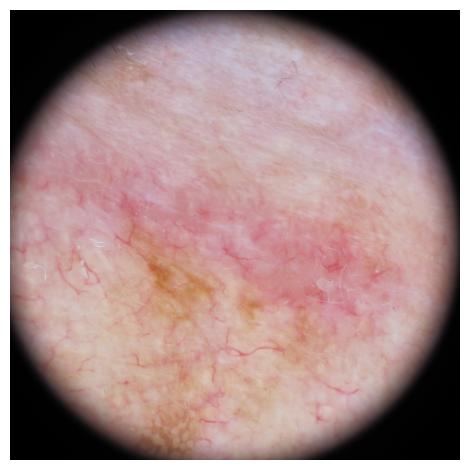

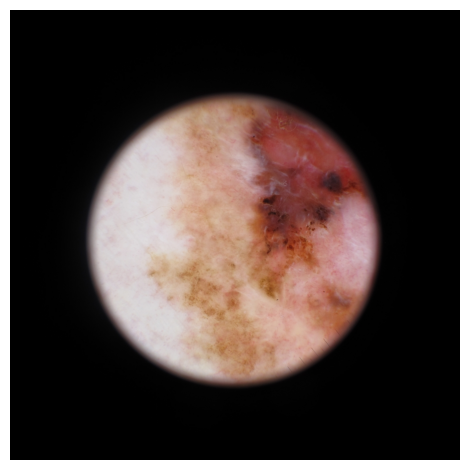

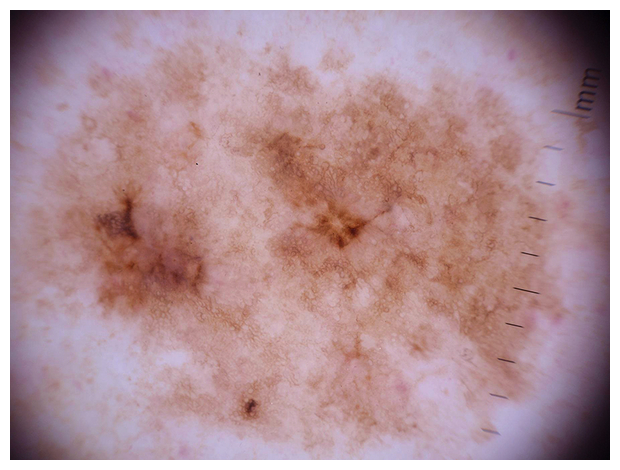

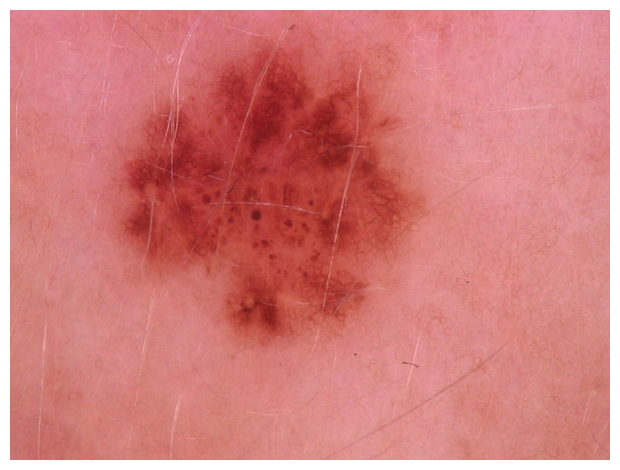

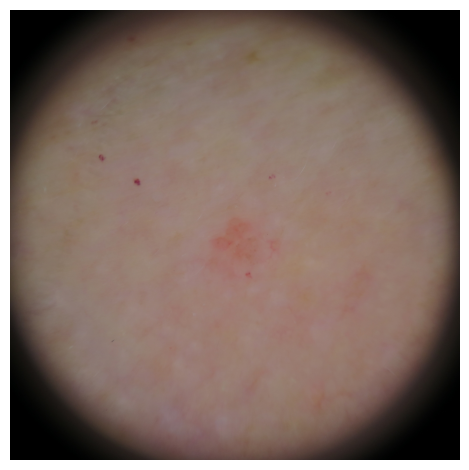

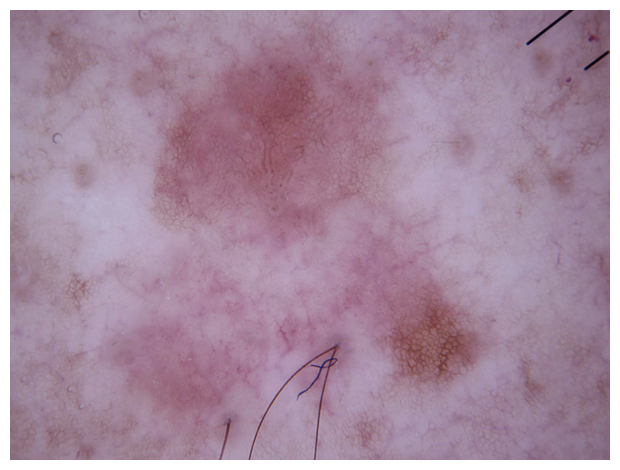

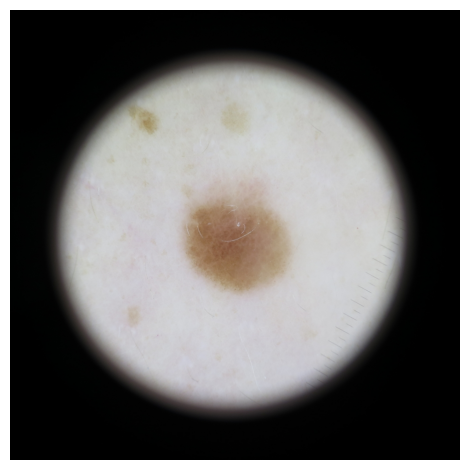

In [18]:
for i, row in df_test[:10].iterrows():
    img_path = row['image_path']
    img = cv.imread(img_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis for cleaner display
    plt.tight_layout()
    plt.show()

In [24]:
class Preprocessing:
    """
       Preprocessing class. This class's purpose is to preprocess the images in the dataset.
    """

    def _hair_removal(self, img, se_width=11, se_height=1, n_orientations=8):
        # Input validation for structuring element dimensions
        if se_width % 2 == 0:
            raise ValueError(f"Structuring element width ({se_width}) must be odd")
        if se_height % 2 == 0:
            raise ValueError(f"Structuring element height ({se_height}) must be odd")

        # Convert the original image to grayscale if it has more than 1 channel
        if len(img.shape) == 3:
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            img_gray = img

        # Create tilted structuring elements
        base = np.zeros((se_width, se_width), dtype=np.uint8)
        for k in range(se_width // 2 - se_height // 2, se_width // 2 + se_height // 2 + 1):
            cv.line(base, (0, k), (se_width, k), 255)

        # Compute rotated structuring elements
        SEs = [base]
        angle_step = 180.0 / n_orientations
        for k in range(1, n_orientations):
            rotation_matrix = cv.getRotationMatrix2D((se_width / 2.0, se_width / 2.0), k * angle_step, 1.0)
            SE = cv.warpAffine(base, rotation_matrix, (se_width, se_width), flags=cv.INTER_NEAREST)
            SEs.append(SE)

        # Initialize sum of blackhat results
        sum_blackhats = np.zeros_like(img_gray, dtype=np.uint16)

        # Apply blackhat operation using each structuring element and accumulate results
        for SE in SEs:
            blackhat = cv.morphologyEx(img_gray, cv.MORPH_BLACKHAT, SE)
            sum_blackhats += blackhat

        # Normalize the sum of blackhats to the range 0-255 and convert to uint8
        cv.normalize(sum_blackhats, sum_blackhats, 0, 255, cv.NORM_MINMAX)
        sum_blackhats = sum_blackhats.astype(np.uint8)

        # Threshold the blackhat sum to create a binary mask for inpainting
        _, thresholded = cv.threshold(sum_blackhats, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)

        # Refine the mask using morphological opening to remove small components
        thresholded = cv.morphologyEx(thresholded, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3)))

        # Dilate the mask slightly to cover the hair regions more effectively
        thresholded = cv.dilate(thresholded, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))

        # Inpaint the original image using the created mask
        if len(img.shape) == 3:
            result = cv.inpaint(img, thresholded, 3, cv.INPAINT_NS)
        else:
            result = cv.inpaint(img_gray, thresholded, 3, cv.INPAINT_NS)

        return result
    
    def _color_constancy(self, img, power=5, gamma=1.4):
        """
        Apply color constancy to the input image using a power transformation and optional gamma correction.

        Parameters:
            img (numpy.ndarray): Input image.
            power (float): Power to use for the power transformation (default is 6).
            gamma (float, optional): Gamma value for gamma correction (default is 2.2).

        Returns:
            numpy.ndarray: Image with color constancy applied.
        """
        # Get the data type of the input image
        img_dtype = img.dtype

        # Apply gamma correction if gamma is provided
        if gamma is not None:
            img = img / 255.0  # Normalize to 0-1
            img = np.power(img, 1 / gamma)
            img = (img * 255).astype('float32')

        # Convert the image to float32 data type for further processing
        img = img.astype('float32')

        # Apply power transformation to the image
        img_power = np.power(img, power)

        # Calculate the mean of img_power along channels (0 and 1)
        rgb_vec = np.power(np.mean(img_power, axis=(0, 1)), 1 / power)

        # Calculate the L2 norm of rgb_vec
        rgb_norm = np.linalg.norm(rgb_vec)

        # Normalize rgb_vec to have unit length
        rgb_vec /= (rgb_norm + 1e-6)  # Added small value to avoid division by zero

        # Scale down rgb_vec to prevent overexposure (tuning parameter)
        scale_factor = 0.8  # Scale down the effect of rgb_vec
        rgb_vec = (1 / (rgb_vec * np.sqrt(3))) * scale_factor

        # Scale img using the adjusted color constancy vector
        img = img * rgb_vec
        img = np.clip(img, 0, 255)

        # Normalize the image to 0-255 if needed
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

        return img.astype(img_dtype)

    
    def _roi(self, img, threshold=50):
        # Image dimensions
        h, w = img.shape[:2]
        
        # Get the minimum dimension to avoid index errors
        min_dim = min(h, w)
        
        # Calculate mean values along the diagonal
        diagonal_values = np.mean(img[np.arange(min_dim), np.arange(min_dim), :], axis=1)

        # Find the first and last points where the threshold is crossed
        above_threshold = np.where(diagonal_values >= threshold)[0]
        if above_threshold.size == 0:
            # If no diagonal value exceeds the threshold, return the original image
            return img
        
        first_cross = above_threshold[0]
        last_cross = above_threshold[-1]
        
        # Set the coordinates to crop the image
        y1 = max(0, first_cross)
        y2 = min(h, last_cross + 1)
        x1 = max(0, first_cross)
        x2 = min(w, last_cross + 1)
        
        # Crop the image using the calculated coordinates
        img_new = img[y1:y2, x1:x2, :]
        
        # Ensure the cropped image is not empty
        if img_new.shape[0] == 0 or img_new.shape[1] == 0:
            return img

        return img_new
    

    def _add_padd_to_image(self, img, padding_size):
        # Get the dimensions of the original image
        height_original, width_original = img.shape

        # Create a new larger image with black padding
        new_height = height_original + 2 * padding_size
        new_width = width_original + 2 * padding_size
        padding_image = np.zeros((new_height, new_width), dtype=np.uint8)

        # Calculate the position to place the original image in the center of the new image
        x_offset = padding_size
        y_offset = padding_size

        # Copy the original image into the center of the new image
        padding_image[y_offset:y_offset + height_original, x_offset:x_offset + width_original] = img

        return padding_image, height_original, width_original

    def _back_original_shape(self, eroded_mask, width_original, height_original, padding_size):
        # Back to the original shape
        crop_x_start = padding_size
        crop_x_end = padding_size + width_original
        crop_y_start = padding_size
        crop_y_end = padding_size + height_original

        # Crop the padded image to the original size
        cropped_mask = 255 - eroded_mask[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

        return cropped_mask

    def _plot_results(self, img, image_file, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image):
        # Create a figure with a larger size
        plt.figure(figsize=(14, 4))

        # Display the original image
        plt.subplot(1, 6, 1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(f'Original: {image_file}', fontsize=5)
        plt.axis('off')

        # Display the hair-removed image
        plt.subplot(1, 6, 2)
        plt.imshow(cv.cvtColor(hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 1: Hair Removal', fontsize=5)
        plt.axis('off')

        # Display the color-normalized image
        plt.subplot(1, 6, 3)
        plt.imshow(cv.cvtColor(cn_hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 2: Color Normalization', fontsize=5)
        plt.axis('off')

        # Display the ROI image
        plt.subplot(1, 6, 4)
        plt.imshow(cv.cvtColor(roi_image, cv.COLOR_BGR2RGB))
        plt.title('Step 3: ROI Image', fontsize=5)
        plt.axis('off')

        # Display the eroded mask
        plt.subplot(1, 6, 5)
        plt.imshow(cv.cvtColor(cropped_mask_3_channels, cv.COLOR_BGR2RGB))
        plt.title('Step 4: Padding + Binary Mask', fontsize=5)
        plt.axis('off')

        # Display the final image
        plt.subplot(1, 6, 6)
        plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
        plt.title('Final Image', fontsize=5)
        plt.axis('off')

        # Adjust the spacing between subplots
        plt.tight_layout()
        plt.savefig("preprocessing.png")
        plt.show()

    def preprocess_image(self, img, image_file, plot_results):
        # Call the function to remove the hairs from the image
        hair_removed_image = self._hair_removal(img)
        # Call the function to normalize the colors
        cn_hair_removed_image = self._color_constancy(hair_removed_image)
        # Call the function to crop the images
        roi_image = self._roi(cn_hair_removed_image)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self._add_padd_to_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        # Plot results
        if plot_results:
            self._plot_results(img, image_file, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image)

        return final_image

    def preprocess_image_ROI(self, img):
        roi_image = self._roi(img)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self._add_padd_to_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        return final_image

## Preprocessing

In [14]:
preprocessing = Preprocessing()

# for class_idx, c in enumerate(selected_images.keys()):
#     for img_idx, img_path in enumerate(selected_images[c]):
#         img = cv2.imread(img_path)
#         preprocessing.preprocess_image(img, img_path, True)

In [22]:
# Initialize variables for mean and standard deviation calculation
channel_sum, channel_squared_sum = np.zeros(3), np.zeros(3)
num_images = len(df_test)  # Total number of images

# Iterate through df_train
for idx, row in df_test.iterrows():
    img_path = row['image_path']
    # Read the image
    img = cv.imread(img_path)

    # Preprocess the image using your preprocessing function
    prepoc_img = preprocessing.preprocess_image(img, img_path, plot_results=False)

    # Convert the preprocessed image to a PyTorch tensor and normalize to [0, 1]
    prepoc_img_tensor = torch.tensor(prepoc_img.transpose(2, 0, 1), dtype=torch.float32) / 255.0  # HWC to CHW

    # Update channel sums
    channel_sum += prepoc_img_tensor.mean(dim=[1, 2]).numpy()
    channel_squared_sum += (prepoc_img_tensor**2).mean(dim=[1, 2]).numpy()

# Calculate the mean and standard deviation
mean = channel_sum / num_images
stddev = np.sqrt(channel_squared_sum / num_images - mean**2)

# Display the results
print("Training Dataset Normalization:")
print("Mean              :", mean)
print("Standard Deviation:", stddev)

## Creating Dataset Class

In [25]:
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None, preprocessor=None):
        self.df = df
        self.file_names = df['image_path'].values
        self.ids = df['id'].values
        self.labels = df['label'].values
        self.transforms = transforms
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        ids = self.ids[index]
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image not found or invalid at path: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")
        
        label = int(self.labels[index])
        
        # Apply preprocessing
        if self.preprocessor:
            img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

        # Apply transformations
        if self.transforms:
            img = self.transforms(image=img)["image"]

        # Convert to tensors
        if isinstance(img, np.ndarray):
            img = np.transpose(img, (2, 0, 1))  # HWC to CHW
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)  # [1]

        return {'image': img_tensor, 'ids': ids, 'label': label_tensor}

## Model

In [10]:
# class ISICModel(nn.Module):
#     def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
#         super(ISICModel, self).__init__()
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Identity()
#         self.model.global_pool = nn.Identity()
#         self.pooling = GeM()
#         self.linear = nn.Linear(in_features, num_classes)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, images):
#         features = self.model(images)
#         pooled_features = self.pooling(features).flatten(1)
#         output = self.sigmoid(self.linear(pooled_features))
#         return output


# class ISICModel(nn.Module):
#     def _init_(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
#         """
#         A binary classification model for skin lesion images using Swin Transformer.
        
#         Args:
#             model_name (str): Name of the model backbone from timm.
#             num_classes (int): Number of output classes. Default is 1 for binary classification.
#             pretrained (bool): Whether to use pretrained weights. Default is True.
#             checkpoint_path (str): Path to a specific checkpoint. Default is None.
#         """
#         super(ISICModel, self)._init_()
#         # Create the base model using timm
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
#         # Get the number of features in the backbone's output
#         in_features = self.model.num_features  # Swin's feature size (e.g., 768)
        
#         # Replace the classifier with an identity layer
#         self.model.head = nn.Identity()
        
#         # Add custom layers
#         self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
#         self.dropout = nn.Dropout(0.5)  # Dropout for regularization
#         self.batch_norm = nn.BatchNorm1d(in_features)
#         self.linear = nn.Linear(in_features, num_classes)  # Output layer
    

#     def forward(self, images):
#         # Print the input shape
#         # print(f"Input Shape: {images.shape}")  # Input to the model
    
#         # Extract features from the backbone
#         features = self.model(images)  # Shape: [batch_size, 7, 7, 768]
#         # print(f"Backbone Output Shape: {features.shape}")  # After passing through the backbone
        
#         # Correctly permute dimensions for pooling
#         features = features.permute(0, 3, 1, 2)  # Change to [batch_size, num_channels, height, width]
        
#         # Apply pooling to reduce height and width
#         pooled_features = self.pooling(features).squeeze(-1).squeeze(-1)  # Shape: [batch_size, num_channels]
#         # print(f"Pooled Features Shape: {pooled_features.shape}")  # After pooling

         
#         # Apply batch normalization
#         normalized_features = self.batch_norm(pooled_features)
        
#         # Apply dropout for regularization
#         dropped_features = self.dropout(normalized_features)
#         # print(f"Dropped Features Shape: {dropped_features.shape}")  # After dropout
        
#         # Apply linear layer for binary classification
#         output = self.linear(dropped_features)  # Shape: [batch_size, num_classes]
#         # print(f"Output Shape: {output.shape}")  # Final output
        
#         return output

# # Initialize the model
# model = ISICModel(
#     model_name=CONFIG['model_name'], 
#     num_classes=CONFIG['num_classes']
# )

# model.to(CONFIG['device']);

In [43]:
class ISICModelSwin(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModelSwin, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        in_features = self.model.num_features
        self.model.head = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(in_features)
        self.linear = nn.Linear(in_features, num_classes)
    
    def forward(self, images):
        features = self.model(images)
        features = features.permute(0, 3, 1, 2)
        pooled_features = self.pooling(features).squeeze(-1).squeeze(-1)
        normalized_features = self.batch_norm(pooled_features)
        dropped_features = self.dropout(normalized_features)
        output = self.linear(dropped_features)
        return output

In [44]:
class ISICModelEfficientNet(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        """
        A binary classification model for skin lesion images.
        
        Args:
            model_name (str): Name of the model backbone from timm.
            num_classes (int): Number of output classes. Default is 1 for binary classification.
            pretrained (bool): Whether to use pretrained weights. Default is True.
            checkpoint_path (str): Path to a specific checkpoint. Default is None.
        """
        super(ISICModelEfficientNet, self).__init__()
        # Create the base model using timm
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
        # Get the number of features in the backbone's classifier
        in_features = self.model.classifier.in_features
        
        # Replace the classifier with an identity layer to use custom pooling and classification
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        
        # Add custom layers
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.batch_norm = nn.BatchNorm1d(in_features)
        self.linear = nn.Linear(in_features, num_classes)  # Single output for binary classification
    

    def forward(self, images):
        # Extract features from the backbone
        features = self.model(images)
        
        # Apply pooling and flatten the features
        pooled_features = self.pooling(features).flatten(1)

        # Apply batch normalization
        normalized_features = self.batch_norm(pooled_features)
        
        # Apply dropout for regularization
        dropped_features = self.dropout(normalized_features)
        
        # Apply linear layer and sigmoid activation for binary classification
        output = self.linear(dropped_features)
        return output


In [45]:
# Define a function to load a model with specific weights
def load_model(model_class, model_name, checkpoint_path, num_classes, device):
    """
    Load a model with pretrained weights.
    
    Args:
        model_class: The model class to instantiate.
        model_name: The name of the model architecture.
        checkpoint_path: Path to the model's checkpoint file.
        num_classes: Number of output classes.
        device: Device to load the model on ('cuda' or 'cpu').
        
    Returns:
        model: Loaded PyTorch model.
    """
    model = model_class(model_name=model_name, num_classes=num_classes, pretrained=False)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move to the specified device
    return model

In [48]:
# List of model configurations (paths and details for each model)
model_configs = [
    {"model_class": ISICModelSwin, "model_name": "swin_tiny_patch4_window7_224", 
     "checkpoint_path": "/kaggle/input/swin_865/pytorch/default/1/best_model_896.pth", "num_classes": CONFIG['num_classes']},
    {"model_class": ISICModelSwin, "model_name": "swin_large_patch4_window7_224", 
     "checkpoint_path": "/kaggle/input/swin_large_9/pytorch/default/1/best_model_swin_large_9.pth", "num_classes": CONFIG['num_classes']},
    # {"model_class": ISICModelResNet, "model_name": "resnet34", 
     # "checkpoint_path": "resnet34_checkpoint.pth", "num_classes": CONFIG['num_classes']},
    {"model_class": ISICModelEfficientNet, "model_name": "tf_efficientnet_b4_ns", 
     "checkpoint_path": "/kaggle/input/effb4_89/pytorch/default/1/best_model_89.pth", "num_classes": CONFIG['num_classes']}
]

# Load all models into a list
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = []

for config in model_configs:
    model = load_model(
        model_class=config['model_class'],
        model_name=config['model_name'],
        checkpoint_path=config['checkpoint_path'],
        num_classes=config['num_classes'],
        device=device
    )
    models.append(model)

print(f"Successfully loaded {len(models)} models for ensemble!")

Successfully loaded 3 models for ensemble!


In [47]:
# Define the model
model = ISICModelSwin(model_name=CONFIG['model_name'], num_classes=CONFIG['num_classes'], pretrained=False)

model.load_state_dict(torch.load(CONFIG['checkpoint_path'], map_location='cpu'))
model.eval()  # Set the model to evaluation mode

# Move to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ISICModelSwin(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=Tru

## Dataloder

In [19]:
def prepare_loaders(df, batch_size, data_transforms=None):
    """
    Prepare test data loader.
    
    Args:
        df (pd.DataFrame): The DataFrame containing image paths and IDs.
        batch_size (int): Batch size for the DataLoader.
        data_transforms (A.Compose, optional): Albumentations transformations. Default is None.
    
    Returns:
        test_loader (DataLoader): DataLoader for the test dataset.
    """
    # Define default transforms if none are provided
    if data_transforms is None:
        data_transforms = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(mean=(0.71142284, 0.72206312, 0.74917489), std=(0.22166623, 0.20692102, 0.16478186)),
            ToTensorV2()
        ])
    
    # Create an instance of the Preprocessing class
    preprocessor = Preprocessing()

    # Create the test dataset
    test_dataset = ISICDataset(
        df=df,
        transforms=data_transforms,
        preprocessor=preprocessor
    )

    # Define a custom collate function
    def custom_collate_fn(batch):
        images = torch.stack([item['image'] for item in batch])  # Stack images
        ids = [item['ids'] for item in batch]  # Collect IDs
        labels = [item['label'] for item in batch]  # Collect IDs
        return {'image': images, 'ids': ids, 'label': labels}

    # Create DataLoader for test dataset
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=False,
        collate_fn=custom_collate_fn,
        pin_memory=True
    )
    
    return test_loader

In [50]:
# Prepare the test loader
valid_loader = prepare_loaders(df=df_valid, batch_size=16)

# Iterate through the DataLoader
for batch in test_loader:
    images = batch['image']
    ids = batch['ids']
    labels = batch['label']
    print(f"Batch images shape: {images.shape}")
    print(f"Batch IDs: {ids}")
    print(f'Labels: {labels}')
    break

Batch images shape: torch.Size([16, 3, 224, 224])
Batch IDs: ['scc00396.jpg', 'bcc02118.jpg', 'bcc02281.jpg', 'mel02759.jpg', 'mel02790.jpg', 'bcc02057.jpg', 'bcc02250.jpg', 'mel03018.jpg', 'mel03075.jpg', 'mel02986.jpg', 'mel03251.jpg', 'bcc02047.jpg', 'mel02918.jpg', 'bcc02186.jpg', 'ack00616.jpg', 'mel02867.jpg']
Labels: [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


## Test

In [31]:
@torch.inference_mode()
def test(model, dataloader, device, output_csv_path):
    """
    Function to test the model and save predictions in a CSV file.
    
    Args:
        model: PyTorch model to test.
        dataloader: DataLoader for the test dataset.
        device: Device to use (e.g., 'cuda' or 'cpu').
        epoch: Current epoch number (for logging purposes).
        output_csv_path: Path to save the CSV file containing predictions.

    Returns:
        None (predictions are saved to the specified CSV file).
    """
    model.eval()
    
    all_predictions = []
    all_image_ids = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        image_ids = data['ids']  # Assuming the DataLoader provides an 'id' field for image IDs
        
        # Forward pass
        outputs = model(images).squeeze()
        
        # Apply softmax or sigmoid based on your task (adjust as needed)
        probabilities = torch.softmax(outputs, dim=1) if outputs.dim() > 1 else torch.sigmoid(outputs)
        
        # Get predicted class indices
        predicted_classes = probabilities.argmax(dim=1).cpu().numpy() if probabilities.dim() > 1 else (probabilities > 0.5).long().cpu().numpy()
        
        # Collect predictions and corresponding IDs
        all_predictions.extend(predicted_classes)
        all_image_ids.extend(image_ids)
    
    # Create a DataFrame for predictions
    results_df = pd.DataFrame({
        'id': all_image_ids,
        'predicted_class': all_predictions
    })
    
    # Save predictions to a CSV file
    results_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")
    
    gc.collect()

In [32]:
output_csv_path = "test_predictions.csv"
test(model, test_loader, device='cuda', output_csv_path=output_csv_path)

100%|██████████| 397/397 [12:31<00:00,  1.89s/it]


Predictions saved to test_predictions.csv


## Ensemble

In [52]:
@torch.inference_mode()
def ensemble_valid(models, dataloader, device):
    """
    Function to perform ensemble predictions using multiple models for binary classification.
    
    Args:
        models: List of PyTorch models to ensemble.
        dataloader: DataLoader for the test dataset.
        device: Device to use (e.g., 'cuda' or 'cpu').
        output_csv_path: Path to save the CSV file containing predictions.

    Returns:
        tuple: All predictions and probabilities for further analysis.
    """
    # Set all models to evaluation mode
    for model in models:
        model.eval()

    all_predictions = []
    all_image_ids = []
    all_probabilities = []
    all_labels = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Ensemble Predicting")
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        image_ids = data['ids']  # Assuming the DataLoader provides an 'id' field for image IDs
        labels = data['label']

        ensemble_outputs = 0  # Initialize ensemble outputs
        for model in models:
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)  # Sigmoid for binary classification
            ensemble_outputs += probabilities

        # Average the probabilities from all models
        averaged_probs = ensemble_outputs / len(models)

        # Apply threshold to averaged probabilities to get binary predictions
        predicted_classes = (averaged_probs > 0.5).long().cpu().numpy()

        # Collect predictions, probabilities, and corresponding IDs
        all_predictions.extend(predicted_classes)
        all_image_ids.extend(image_ids)
        all_probabilities.extend(averaged_probs.cpu().numpy())
        all_labels.extend(labels)
        
    
    # Create a DataFrame for predictions
    print(f'Classification Report: {classification_report(all_labels, all_predictions, target_names=["others", "nevus"])}')
    gc.collect()

In [29]:
@torch.inference_mode()
def ensemble_test(models, dataloader, device, output_csv_path):
    """
    Function to perform ensemble predictions using multiple models for binary classification.
    
    Args:
        models: List of PyTorch models to ensemble.
        dataloader: DataLoader for the test dataset.
        device: Device to use (e.g., 'cuda' or 'cpu').
        output_csv_path: Path to save the CSV file containing predictions.

    Returns:
        tuple: All predictions and probabilities for further analysis.
    """
    # Set all models to evaluation mode
    for model in models:
        model.eval()

    all_predictions = []
    all_image_ids = []
    all_probabilities = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Ensemble Predicting")
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        image_ids = data['ids']  # Assuming the DataLoader provides an 'id' field for image IDs

        ensemble_outputs = 0  # Initialize ensemble outputs
        for model in models:
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)  # Sigmoid for binary classification
            ensemble_outputs += probabilities

        # Average the probabilities from all models
        averaged_probs = ensemble_outputs / len(models)

        # Apply threshold to averaged probabilities to get binary predictions
        predicted_classes = (averaged_probs > 0.5).long().cpu().numpy()

        # Collect predictions, probabilities, and corresponding IDs
        all_predictions.extend(predicted_classes)
        all_image_ids.extend(image_ids)
        all_probabilities.extend(averaged_probs.cpu().numpy())

    # Create a DataFrame for predictions
    results_df = pd.DataFrame({
        'id': all_image_ids,
        'predicted_class': all_predictions
    })
    
    # Save predictions to a CSV file
    results_df.to_csv(output_csv_path, index=False)
    print(f"Ensemble predictions saved to {output_csv_path}")
    
    gc.collect()
    return all_predictions, all_probabilities


In [53]:
model_list = models
ensemble_valid(model_list, valid_loader, device='cuda')

Ensemble Predicting: 100%|██████████| 238/238 [07:46<00:00,  1.96s/it]


Classification Report:               precision    recall  f1-score   support

      others       0.84      0.86      0.85      1865
       nevus       0.86      0.84      0.85      1931

    accuracy                           0.85      3796
   macro avg       0.85      0.85      0.85      3796
weighted avg       0.85      0.85      0.85      3796



In [30]:
# List of models for ensemble
model_list = models  # Replace with your models (already loaded and moved to the device)

output_csv_path = "ensemble_test_predictions.csv"
predictions, probabilities = ensemble_test(model_list, test_loader, device='cuda', output_csv_path=output_csv_path)

Ensemble Predicting: 100%|██████████| 397/397 [12:28<00:00,  1.88s/it]


Ensemble predictions saved to ensemble_test_predictions.csv
